### import supporting packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from datetime import datetime, timedelta, date
import glob,os
import time
import sys
#import warnings
#warnings.filterwarnings("ignore")

# prep data 

### acquire proto2 data

In [2]:
path_corrected_proto2='despiked_proto2/'

proto2_corrected_filepaths=[]
for file in sorted(os.listdir(path_corrected_proto2)):
    if file != '.ipynb_checkpoints':
        proto2_corrected_filepaths.append(path_corrected_proto2+file)
    
proto2_corrected_from_files=(pd.read_csv(f,on_bad_lines='skip') for f in proto2_corrected_filepaths)
proto2_corrected=pd.concat(proto2_corrected_from_files)

times=pd.to_datetime(proto2_corrected['Unnamed: 0'],format='%Y-%m-%d %H:%M:%S')
proto2_corrected=proto2_corrected.set_index(times)
proto2_corrected.index.names=['date']
proto2_corrected=proto2_corrected.drop('Unnamed: 0',1)
proto2_corrected;

#take high frequency proto2 data and resample to hourly mean
houravg=proto2_corrected.drop(columns=['datetimestamp']).apply(pd.to_numeric).resample('60min').mean()

/tmp/ipykernel_2113308/2948066038.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  proto2_corrected=proto2_corrected.drop('Unnamed: 0',1)


### acquire DEC reference data 

In [3]:
#get the epa filenames

path_epa='/data/aq/DEC/csv/'

epa_filepaths=[]
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)
    
epa_from_files=(pd.read_csv(f) for f in epa_filepaths)
epa_df=pd.concat(epa_from_files)
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))

### define some dictionaries that tie the concentration number code to its appropriate name

In [4]:
#set dictionary that matches varid to field name
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}
epa_table={42101:'Trace CO (ppb)',44201:'O3 (ppb)',42601:'NOx (ppb)',42602:'NO2 (ppb)',88101:'PM25FEM (ug/m3)'}

### toss out times in the DEC observations where there is no recorded data in proto2

In [5]:
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;

### delineate months 

In [6]:
# Select date ranges corresponding to months 
july = (epa_df_matching_proto2['date'] >= '2021-07-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-07-31 23:00:00') 
august = (epa_df_matching_proto2['date'] >= '2021-08-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-08-31 23:00:00') 
september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
october = (epa_df_matching_proto2['date'] >= '2021-10-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-10-31 23:00:00') 
november = (epa_df_matching_proto2['date'] >= '2021-11-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-11-31 23:00:00') 
month_list = [july, august, september, october, november]

# data are ready - begin calibration process 

## ... start by defining functions 

### generate regression coefficients script 

In [7]:
import pandas as pd
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

def generate_coefficients(training_predictors, training_reference_concentrations, method):
    '''
    INPUT...
    training_predictors = dataframe corresponding of predictors in training period 
    training_reference_concentrations = dataframe containing reference concentrations (DEC) during training period
    
    method = 'linear' or 'quadratic' (only LINEAR works as of 02/08/2023)    
    ===========================================================
    RETURNS...
    00 = coefficient + y-intercepts of regression equation as a dictionary (this is what's important!)
    01 = model (kept for documentation purposes)
    '''
    
    if method == 'linear' or method == 'Linear' or method == 'LINEAR':

        #https://www.statology.org/statsmodels-linear-regression-p-value/
        y = training_reference_concentrations
        x = training_predictors
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        analysis = model.summary()
         
        # coefficient dictionary
        coefs=model.params
        coef_dict={}
        # pvalue dictionary
        pvalues=model.pvalues
        pvalue_dict={}
        
        for num_of_predictors in range(len(coefs)):
            if num_of_predictors == 0:
                coef_dict['Y-intercept (constant term)']=coefs[num_of_predictors]
                pvalue_dict['Y-intercept (constant term)']=pvalues[num_of_predictors]

            else:
                coef_dict[training_predictors.columns[num_of_predictors-1]]=coefs[num_of_predictors]
                pvalue_dict[training_predictors.columns[num_of_predictors-1]]=pvalues[num_of_predictors]
        
        output = {'coef_dict':coef_dict,'pvalue_dict':pvalue_dict,'analysis':analysis,'model':model}
    
        return output

In [8]:
def generate_coefficients_optimize_bypvalue(training_predictors, testing_predictors, testing_reference_concentrations):
    ''' *** UNFINISHED 
    INPUT...
    training_predictors = dataframe of training period predictors 
    testing_predictors = dataframe of testing period predictors 
    testing_reference_concentrations = 
    
    ===========================================================
    RETURNS...
    calibrated_data = pandas series that contains date (x) and calibrated data (y)
    '''
    coefficients = generate_coefficients(training_predictors,training_reference_concentrations,'linear') # initial regression with all coefficients 
    
    for predictor in range(len(training_predictors.columns)):
        for key,value in coefficients['pvalue_dict'].items():
            if value > 0.05 and key != 'Y-intercept (constant term)':
                print('Removing predictor...',key,' with p-value', str(round(value,2)))
                training_predictors = training_predictors.drop(columns=[str(key)])
                testing_predictors = testing_predictors.drop(columns=[str(key)])

            coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')
            
    return coefficients['coef_dict']

In [9]:
def calibrate(coef_dict, testing_predictors):
    '''
    INPUT...
    coef_dict = dictionary of regression coefficients generated using the generate_coefficients script 
    testing_data_input = dataframe containing testing concentrations, must include IDENTICAL column names as the training data
    input from the generate_coefficients script to work properly 
    
    ===========================================================
    RETURNS...
    calibrated_data = pandas series that contains date (x) and calibrated data (y)
    '''
        
    calibrated_data = coef_dict['Y-intercept (constant term)']
    print('Beginning calibration... starting with y-intercept = ', calibrated_data)

    for key,value in coef_dict.items():
        if key != 'Y-intercept (constant term)':
            print('Calibrating with coefficient...', coef_dict[key], 'for variable', key)
            calibrated_data += coef_dict[key]*testing_predictors[key]
            print('Coefficient done')
    print('Calibration completed!')
            
    return calibrated_data

## apply functions to prepped data 

CO
Removing predictors with p-value < 0.05
Removing predictor... Temp²  with p-value 0.25
Removing predictor... Weekday Binary  with p-value 0.44
Beginning calibration... starting with y-intercept =  -164.47806851119435
Calibrating with coefficient... 10.12473038650767 for variable Temp
Coefficient done
Calibrating with coefficient... 2.172711511660729 for variable RH
Coefficient done
Calibrating with coefficient... -0.10003961447399148 for variable T*RH
Coefficient done
Calibrating with coefficient... -60.363121931252266 for variable T*ΔVolt
Coefficient done
Calibrating with coefficient... 3347.6485634017554 for variable ΔVolt
Coefficient done
Calibration completed!
Plotting for  CO ...
Saving figure as... CO_September_pvalue-opt


O3
Removing predictors with p-value < 0.05
Removing predictor... Temp  with p-value 0.73
Removing predictor... Weekday Binary  with p-value 0.38
Beginning calibration... starting with y-intercept =  -68.42980387392261
Calibrating with coefficient... 0.06742

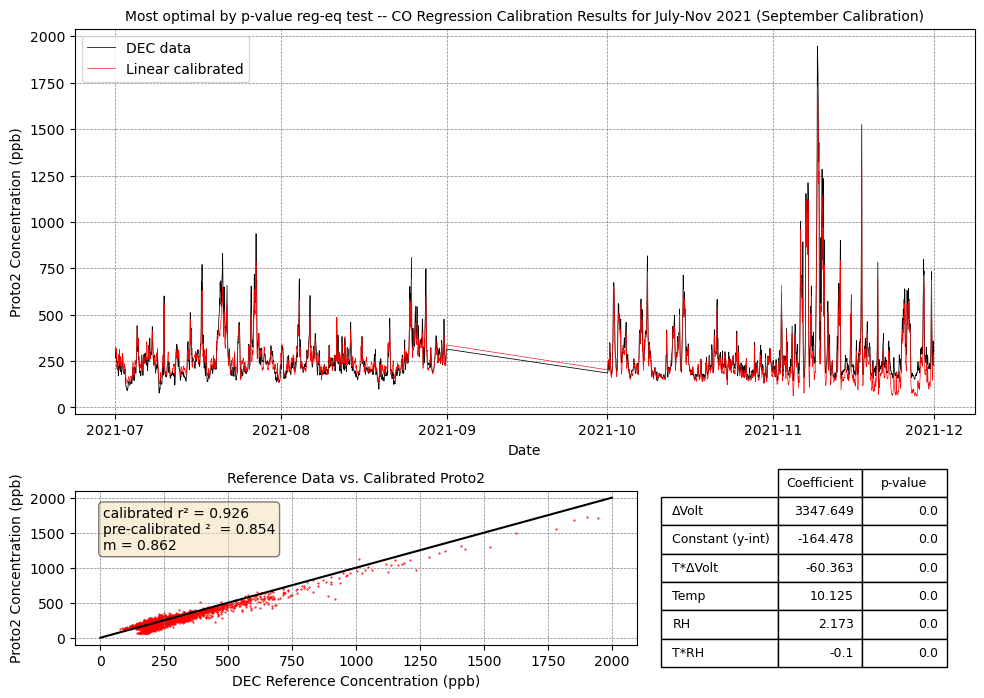

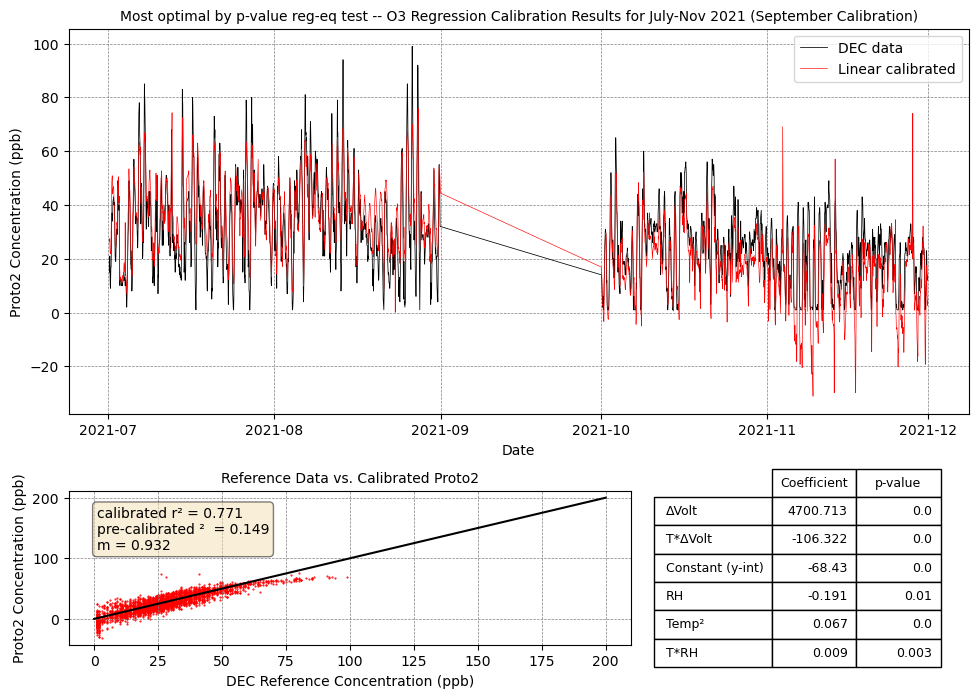

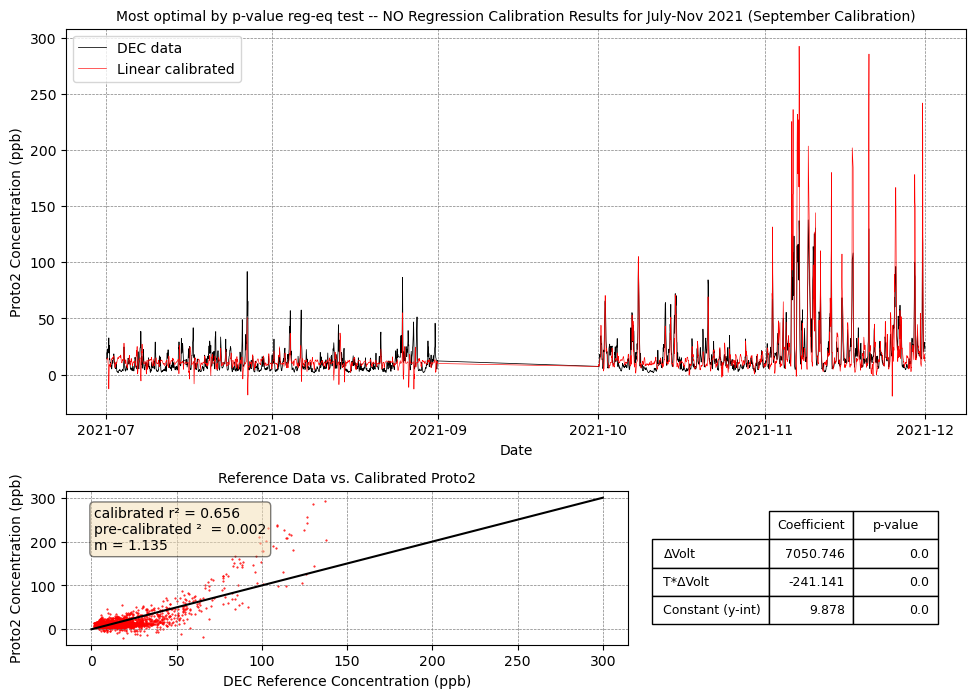

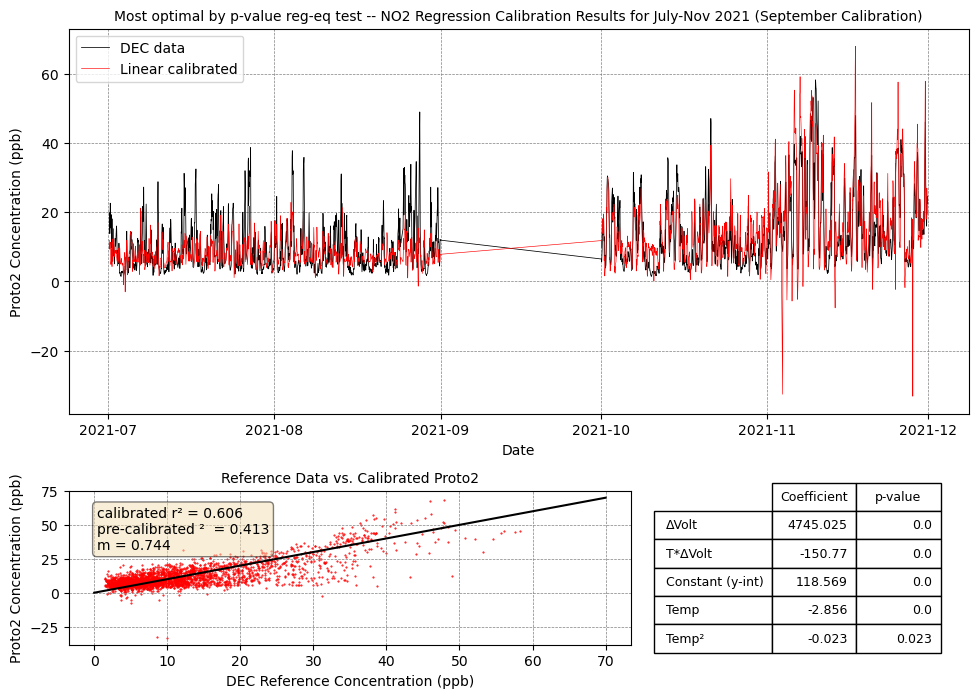

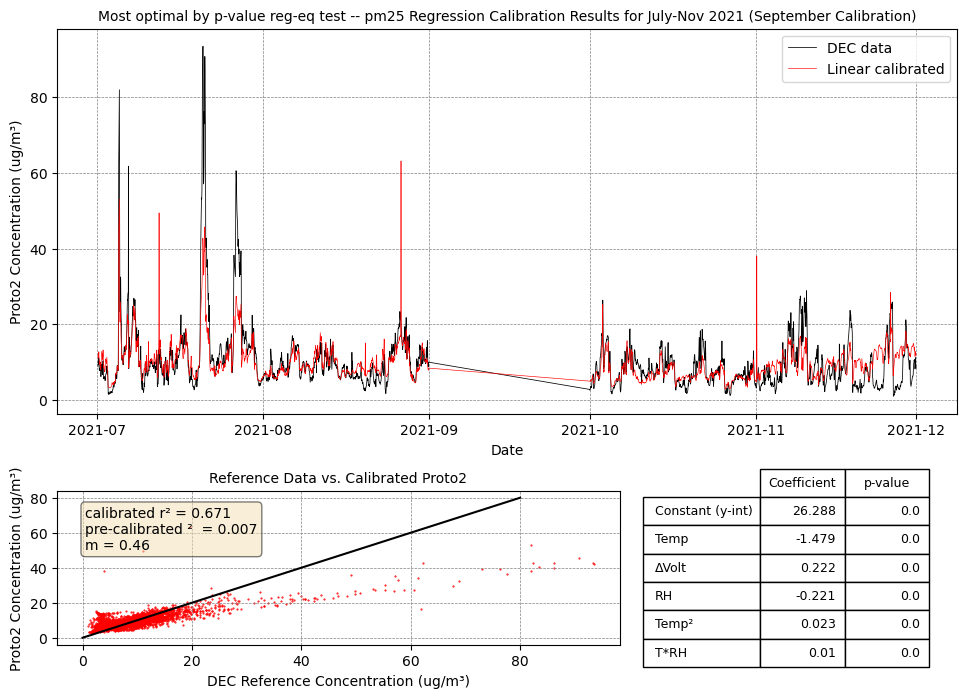

In [10]:
#the observed concentrations and proto2 data are using different timezones. apply a 5 hour fix to shift them over
#long term it may be wise to just correct proto2 data and rewrite it as a file
tshift=5

#specify the method you want for the regression
method='linear'

#define an empty dictionary to hold output
vd={}
model_directory = {}

# CO:42101  O3NO2:44201  NO:42601  NO2:42602 PM2.5:88101
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:


    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    if var_id==44201:
        epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
        epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)

    else:
        epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
        epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)


    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,houravg],axis=1).dropna()

    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        combined_df['O3_ppb']= combined_df['O3NO2_ppb']-combined_df['NO2_ppb']
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'

    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'

    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]

        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'


    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    
    # some fun time predictors 
    combined_df_filtered['decimal_day'] = combined_df_filtered.index.dayofyear # create a column for decimal day; aka time predictor 
    
    combined_df_filtered['dayofweek'] = combined_df_filtered.index.dayofweek # creates column of weekday numbers 
    combined_df_filtered.loc[combined_df_filtered['dayofweek'] <= 4, 'weekday_binary'] = 1 # converts weekdays to 0 (if Zamora, now 1) 
    combined_df_filtered.loc[combined_df_filtered['dayofweek'] > 4, 'weekday_binary'] = 0 # converts weekends to 1 (if Zamora, now 0) 
    
    daylight_mask = (combined_df_filtered.index >= '06:00:00') & (combined_df_filtered.index  <= '23:00:00') # delinate daytime
    combined_df_filtered.loc[daylight_mask, 'daylight_hours_binary'] = 1 # converts daytime to 1
    combined_df_filtered['daylight_hours_binary'] = combined_df_filtered['daylight_hours_binary'].fillna(0) # nighttime is 0
    
    # delineate training and test periods 
    combined_df_filtered_training=combined_df_filtered.loc[september]
    combined_df_filtered_testing=combined_df_filtered.loc[july+august+october+november]

                      
    ## training fields using proto2_QC.csv 
    training_reference_concentrations = combined_df_filtered_training['value']
    training_data = [combined_df_filtered_training['temp_sht31_degC'], # T
                     combined_df_filtered_training['temp_sht31_degC']**2, # T^2
                     combined_df_filtered_training['rh_sht31_percent'], # RH
                     combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training['rh_sht31_percent'], # T-RH interaction
                     combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training[gname+'_voltdiff'], # T-sensor interaction
                     combined_df_filtered_training[gname+'_voltdiff'], # sensor
                     combined_df_filtered_training['weekday_binary']] # binary weekend
                     #combined_df_filtered_training['decimal_day']] # decimal day
        
    training_data_input = pd.DataFrame(training_data, index=['Temp','Temp²','RH','T*RH','T*ΔVolt','ΔVolt','Weekday Binary']).transpose()
        
    
    # testing fields using proto2_QC.csv 
    testing_reference_concentrations = combined_df_filtered_testing['value']
    testing_data = [combined_df_filtered_testing['temp_sht31_degC'], # T
                    combined_df_filtered_testing['temp_sht31_degC']**2, # T^2
                    combined_df_filtered_testing['rh_sht31_percent'], # RH
                    combined_df_filtered_testing['temp_sht31_degC']*combined_df_filtered_testing['rh_sht31_percent'], # T-RH interaction
                    combined_df_filtered_testing['temp_sht31_degC']*combined_df_filtered_testing[gname+'_voltdiff'], # T-sensor interaction
                    combined_df_filtered_testing[gname+'_voltdiff'], # sensor
                    combined_df_filtered_testing['weekday_binary']] # binary weekend
                    #combined_df_filtered_testing['decimal_day']] # decimal day
    
    testing_data_input = pd.DataFrame(testing_data, index=['Temp','Temp²','RH','T*RH','T*ΔVolt','ΔVolt','Weekday Binary']).transpose()
    precalibrated_obs = combined_df_filtered_testing[gname+unit]
    
    print(gname)
    
    coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')
    print('Removing predictors with p-value < 0.05')
    for predictor in range(len(training_data_input.columns)):
        for key,value in coefficients['pvalue_dict'].items():
            if value > 0.05 and key != 'Y-intercept (constant term)':
                print('Removing predictor...',key,' with p-value', str(round(value,2)))
                training_data_input = training_data_input.drop(columns=[str(key)])
                testing_data_input = testing_data_input.drop(columns=[str(key)])

        coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')    
    
    calibrated_data = calibrate(coefficients['coef_dict'], testing_data_input)
    
    model = gname+'_model'
    model_name = gname+'_model'
    
    training_period_month = str(pd.DatetimeIndex(combined_df_filtered_training.index).month_name()[1])

    testing_period = testing_reference_concentrations.index
       
    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    
    fig = plt.subplots(figsize=(10,8))
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1)
    n=len(testing_reference_concentrations)
    r2=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    r2_pre=(((n*(precalibrated_obs*testing_reference_concentrations).sum())-(precalibrated_obs.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(precalibrated_obs**2).sum()-precalibrated_obs.sum()**2)))**2
    #r2 = (sm.OLS(testing_reference_concentrations, calibrated_data).fit()).rsquared(fit_intercept=False)
    #r2 = (sm.OLS(testing_reference_concentrations,sm.add_constant(calibrated_data)).fit()).rsquared # CORRECT R2

    #r2_pre = (sm.OLS(testing_reference_concentrations, precalibrated_obs).fit()).rsquared

    ''' DEC vs. Calibrated time series plot (top) '''
    time_series = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)
    time_series.set_title('time_series')
    time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.55)
    time_series.plot(testing_period,calibrated_data,label='Linear calibrated', color='red',linewidth=0.45)
    #time_series.plot(testing_period,precalibrated_obs,label='pre-calibrated obs', color='blue',linewidth=0.45)

    time_series.legend()  
    time_series.set_title('Most optimal by p-value reg-eq test -- '+gname+' Regression Calibration Results for July-Nov 2021 ('+training_period_month+' Calibration)', fontsize=10)
    time_series.set_xlabel('Date')
    time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 
    
    ''' uncomment to get specific date windows '''
    #time_series.set_xlim([date(2021,7,1), date(2021,7,31)])
    #time_series.set_xlim([date(2021,8,1), date(2021,8,31)])
    #time_series.set_xlim([date(2021,9,1), date(2021,9,30)])
    #time_series.set_xlim([date(2021,10,1), date(2021,10,31)])
    #time_series.set_xlim([date(2021,11,1), date(2021,11,30)])
    #time_series.set_xlim([date(2021,11,21), date(2021,11,30)])
    #time_series.set_xlim([date(2021,7,1), date(2021,7,7)])

    ''' DEC vs. Calibrated trend  plot (bottom left) '''
    data_series = plt.subplot2grid((3, 3), (2, 0), colspan=2)
    data_series.set_title('data_series')
    data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 300
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    data_series.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    data_series.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
    #data_series.scatter(testing_reference_concentrations,precalibrated_obs,color='blue',s=0.25)

    data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
    data_series.text(0.05, 0.90, 'calibrated r² = '+str(r2.round(3))+'\npre-calibrated ²  = '+str(r2_pre.round(3))+'\nm = '+str(m[0].round(3)), 
                     transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ''' Regression Coefficient Table (bottom right) '''
    table_data = pd.DataFrame()
    table_data = table_data.append([coefficients['coef_dict'], coefficients['pvalue_dict']],ignore_index=True).transpose().rename(columns = {0:'Coefficient', 1:'p-value'}, 
                                                                                                                                  index={'Y-intercept (constant term)':'Constant (y-int)'}).round(3)
    table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    table = plt.subplot2grid((3, 3), (2, 2))
    #table.text(-0.0912,0.07,'Regression Coefficients Table')
    #hide the axes
    table.patch.set_visible(False)
    table.axis('off')
    table.axis('tight')
    regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, colLabels = table_data.columns,loc='center')
    regression_table.scale(0.75,2)
    regression_table.set_fontsize(15)

    plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)
    #print('===')
    #print('Uncalibrated r² = ', coefficients['model'].rsquared.round(2))
    #print('Calibration r²  = ', r2.round(2))
    figname = str(gname+'_'+training_period_month+'_pvalue-opt_with_uncalibratedobs')
    figname = str(gname+'_'+training_period_month+'_pvalue-opt')


    print('Saving figure as...',figname)
    filepath = '/data/shared/ehojeily/pvalue_optimization_plots/'
    #plt.savefig(filepath+figname+'.png',bbox_inches='tight',dpi=300)
    
    '''
    with open(filepath+'readme.txt', 'w') as f:
        f.write('Proto2 calibration analysis plots using generate_coefficients and calibrate function. \n Script used: pvalue_draft2.ipynb')
    '''
    print('\n')

In [13]:
calibrated_data

date
2021-07-01 05:00:00    330.516704
2021-07-01 06:00:00    293.075025
2021-07-01 07:00:00    318.763638
2021-07-01 08:00:00    273.561560
2021-07-01 09:00:00    289.190348
                          ...    
2021-11-30 19:00:00    245.582674
2021-11-30 20:00:00    288.520258
2021-11-30 21:00:00    226.352363
2021-11-30 22:00:00    231.895228
2021-11-30 23:00:00    233.423323
Name: Temp, Length: 2886, dtype: float64

In [14]:
testing_reference_concentrations

date
2021-07-01 05:00:00    303.13
2021-07-01 06:00:00    267.55
2021-07-01 07:00:00    315.35
2021-07-01 08:00:00    248.12
2021-07-01 09:00:00    293.88
                        ...  
2021-11-30 19:00:00    300.32
2021-11-30 20:00:00    358.53
2021-11-30 21:00:00    293.08
2021-11-30 22:00:00    303.17
2021-11-30 23:00:00    310.75
Name: value, Length: 2886, dtype: float64

In [18]:
r2 = (sm.OLS(testing_reference_concentrations,sm.add_constant(calibrated_data)).fit()).rsquared
r2

0.9259282122798485

In [20]:
r2 = (sm.OLS(testing_reference_concentrations,(calibrated_data)).fit()).rsquared
r2

0.9815220943183036

In [22]:
n=len(testing_reference_concentrations)
r2=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
    /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
             (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
r2

0.9259282122798498